Here is my first try with Kaggle Notebook and competition.
I intend to find out what I can do and start preparing some methods to tackle the data coming in my way :-)
Don' t expect brights ideas or polished code here.

In [1]:
#Library used in this notebook
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

In [2]:
#Loading the data
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# We have a test set but no cross-validation one. Let's fix that

perc_cv = 0.2 #x100 % 
rows = random.sample(list(train_data.index), int(len(train_data) * perc_cv))
cv_set = train_data.ix[rows]
training_set = train_data.drop(rows)
training_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


In [4]:
# First thing, let's rework our sets to extract features
def one_hot_conversion(data):
    return pd.get_dummies(training_set, columns=['Pclass', 'Sex', 'Embarked'])
# useless is pretty strong, let's say not use in the model(yet)
def remove_useless_columns(data):
    return data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
# Then, let's extract the labels (survived)
def extract_labels(data):
    return (data.drop(['Survived'], axis=1),
            data['Survived'].to_frame())
def prepare_data(data):
    hot_training = one_hot_conversion(data)
    hot_training = remove_useless_columns(hot_training)
    # Fill Na/NaN with 0 (not ideal but ok for a first try I guess)
    hot_training = hot_training.fillna(0)
    return hot_training
# training data
final_train_set = prepare_data(training_set)
final_train_set, final_train_labels = extract_labels(final_train_set)
# cv data
final_cv_set = prepare_data(cv_set)
final_cv_set, final_cv_labels = extract_labels(final_cv_set)

In [5]:
# Convert the sets to numpy dataframe
final_train_set = final_train_set.as_matrix()
final_train_labels = final_train_labels.as_matrix()
final_cv_set = final_cv_set.as_matrix()
final_cv_labels = final_cv_labels.as_matrix()

In [6]:
# Here the tensorflow stuff
# First, let's try with logistic regression
tf.reset_default_graph()

data = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

# weights and bias
weights = tf.Variable(tf.truncated_normal([final_train_set.shape[1], 1]))
bias = tf.Variable(tf.truncated_normal([1,1]))

# Results
z = tf.matmul(data, weights) + bias
H = tf.sigmoid(z)

cost_function = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=z, labels=labels))

# accuracy
decision_vector = tf.round(H)
correct_prediction = tf.equal(labels, decision_vector)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) * 100

# GD
train_step = tf.train.GradientDescentOptimizer(0.003).minimize(cost_function)

init = tf.global_variables_initializer()



In [8]:
# Let go training

# TF Session + init
sess = tf.Session()
sess.run(init)

# Turbo training
nb_cycle = 100000

# cost/acc memory
cost_training_mem = []
cost_cv_mem = []
acc_training_mem = []
acc_cv_mem = []

for cycle in range(nb_cycle):
    # training
    ts, cost, acc = sess.run([train_step, cost_function, accuracy],
                            feed_dict={data: final_train_set, labels: final_train_labels})
    cost_training_mem.append(cost)
    acc_training_mem.append(acc)
    # Cross validation
    cost, acc = sess.run([cost_function, accuracy],
                         feed_dict={data: final_cv_set, labels: final_cv_labels})
    cost_cv_mem.append(cost)
    acc_cv_mem.append(acc)
    if cycle % 1000 == 0:
        print('-' * 10)
        print('cycle: {}'.format(cycle))
        print('cost training: {}'.format(cost_training_mem[-1]))
        print('accuracy training: {}%'.format(acc_training_mem[-1]))
        print('cost cv: {}'.format(cost_cv_mem[-1]))
        print('accuracy cv: {}%'.format(acc_cv_mem[-1]))

----------
cycle: 0
cost training: 11.802703857421875
accuracy training: 37.727909088134766%
cost cv: 11.295707702636719
accuracy cv: 37.8681640625%
----------
cycle: 1000
cost training: 0.8468309640884399
accuracy training: 54.41794967651367%
cost cv: 0.8465902209281921
accuracy cv: 54.41794967651367%
----------
cycle: 2000
cost training: 0.6787082552909851
accuracy training: 64.2356185913086%
cost cv: 0.6785924434661865
accuracy cv: 64.2356185913086%
----------
cycle: 3000
cost training: 0.5912427306175232
accuracy training: 71.10799407958984%
cost cv: 0.5911772847175598
accuracy cv: 71.10799407958984%
----------
cycle: 4000
cost training: 0.5397866368293762
accuracy training: 73.21178436279297%
cost cv: 0.5397465825080872
accuracy cv: 73.21178436279297%
----------
cycle: 5000
cost training: 0.5076714754104614
accuracy training: 78.54137420654297%
cost cv: 0.5076459646224976
accuracy cv: 78.54137420654297%
----------
cycle: 6000
cost training: 0.4869481921195984
accuracy training: 79

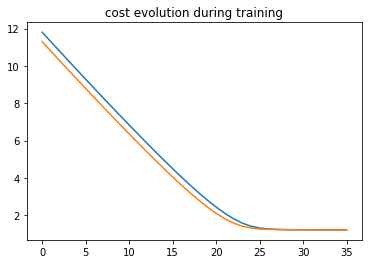

In [13]:
%matplotlib inline
limit_step = 36
plt.plot(np.array([cost_training_mem[:limit_step],cost_cv_mem[:limit_step]]).transpose())
plt.title('cost evolution during training')
#plt.ylim(0.70,2.5)
plt.show()

81% percent, not bad for a first try using a simple logistic regression.

The cost function gives similar result for training and cross validation sets. This is a sign that the model is **underfitting** the data. This was expected. Several leads to fix that:

- Find a good way to deal with NaN values. I put 0, it might not be the right thing to do. Maybe NaNs are introduced during the import of the data file. (Notes talk about estimated age for example)
- Get more data. that would be difficult. Or maybe we can borrow a DeLorean and sell more tickets to the Titanic but that would be a bit difficult and criminal
- Engineer new features. Kaggle provides a [link][1] about that. And some of the data are not used in this model (cabin, name, ticket number). Maybe:
 - ticket number has a relation with where you are on the ship (especially for 3rd class) or maybe it was used to select who would have a place on lifeboats;
 - the format of the "cabin" column indicates where your cabin is on the boat. Then we might be able to extract a geographic position on the ship;
  - we can use good old higher order feature introduction (X1 => X1^2, ...);
  - increase model's capacity. Like using neural network instead of our single logistic unit.


  [1]: https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/